In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import date
from pandas_datareader import data as pdr
import talib as ta



symbols  = [ 'SPY', "QQQ", "VGK", "SCZ", "EWJ", "EEM", #eq
           'REM', "VNQ", "RWX", # re
           'TIP', "IEF", "TLT", "BWX", #fi
           'DBC', "GLD", #como
           'twtr', 'intc', 'tsm']
 
stocks = yf.download(symbols, 
                  start='2014-01-01', 
                  end= date.today(),
                  interval = "1d",
                  threads = True,
                  progress=False)[['Adj Close','High','Low','Volume',]]
symbols_vol = []
for x in symbols:
    symbols_vol.append(x)
    symbols_vol.append(x+'_High')
    symbols_vol.append(x+'_Low')
    symbols_vol.append(x+'_Volume')
    
    
stocks.columns = symbols_vol
stocks

,SPY,SPY_High,SPY_Low,SPY_Volume,QQQ,QQQ_High,QQQ_Low,QQQ_Volume,VGK,VGK_High,...,twtr_Low,twtr_Volume,intc,intc_High,intc_Low,intc_Volume,tsm,tsm_High,tsm_Low,tsm_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2013-12-31,27.015553,24.931597,35.291862,42.804008,116.120003,86.274818,20.659193,81.704720,20.569321,27.689833,...,497775,740800,325700,86119900,1010000,7218600,7647200,27814600,3452300,5576900
2014-01-02,26.847115,24.572100,33.932537,42.098835,118.000000,86.613892,20.523905,81.063774,20.712162,27.165604,...,285900,691100,724400,119636900,681500,8580800,6029100,29246400,6412200,5829600
2014-01-03,26.781612,24.416641,33.873432,42.345642,119.290001,86.561668,20.515945,80.478584,20.837149,27.313463,...,193450,332100,458700,81390600,389700,4083800,11362700,33207200,2534800,2771700
2014-01-06,26.898582,24.445789,33.552608,42.204601,119.500000,86.805107,20.261286,80.181366,20.962139,27.219364,...,233400,510700,1052600,108028200,1406700,7796200,10370200,27243700,3622000,2917500
2014-01-07,26.917295,24.426357,33.696129,42.380909,118.820000,86.944237,20.364740,80.924461,21.069267,27.266411,...,245350,417000,242100,86144200,392600,4428100,13083100,31748400,3620500,2582600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-25,25.879999,27.160000,45.049999,62.740002,182.380005,106.080002,51.830002,359.350006,32.549999,33.900002,...,499000,73500,1154600,77026100,2761800,25684500,7432100,20736500,9512500,4495100
2022-03-28,25.820000,25.980000,45.200001,61.799999,179.059998,106.320000,51.509998,364.910004,32.590000,33.900002,...,405600,148600,1883800,68529800,2815400,17657800,8151200,14225600,8527200,4130800
2022-03-29,25.860001,26.080000,45.970001,63.020000,179.139999,106.849998,52.250000,371.190002,33.240002,34.630001,...,671600,111100,7058200,86581500,3139300,19319700,14076200,17855400,9605900,5350500


In [5]:
def compute_signals(stocks):
    signal = pd.DataFrame()
    signal['Date'] = stocks.index
    for x in stocks.columns:
        if x.split('_')[-1] not in ['High','Low','Volume']:
            C = CCI(stocks,14,x)[0]
            Macd = ta.MACD(stocks[x])
            dicto = {str(x): stocks[x].values,
                     str(x) + '_returns':np.insert(np.log(stocks[x].values/stocks[x].shift(1).values)[1:],0,0),
                     str(x) + '_High':stocks[x + '_High'].values,
                     str(x) + '_Low':stocks[x + '_Low'].values,
                     str(x) + '_Volume':stocks[x + '_Volume'].values,
                     str(x) + '_RSI_14':ta.RSI(stocks[x],14).values,
                     str(x) + '_STOCHRSI':ta.STOCHRSI(stocks[x])[1].values,
                     str(x) + '_MOM':ta.MOM(stocks[x]).values,
                     str(x) + '_MACD_0':Macd[0].values,
                     str(x) + '_MACD_1':Macd[1].values,
                     str(x) + '_MACD_2':Macd[2].values,
                     str(x) + '_UpperBB': BBANDS(stocks[x], 50).UpperBB.values,
                     str(x) + '_LowerBB': BBANDS(stocks[x], 50).LowerBB.values,
                     str(x) + '_Rate-of-Change': ROC(stocks[x],5).values,
                     str(x) + '_SMA_5': SMA(stocks[x],5).values,
                     str(x) + '_EMA_5': EWMA(stocks[x],5).values,
                     str(x) + '_SMA_20': SMA(stocks[x],20).values,
                     str(x) + '_EMA_20': EWMA(stocks[x],20).values,
                     str(x) + '_EVM_10': EVM(stocks,10,x).values,
                     str(x) + '_FI_1': ForceIndex(stocks,1,x).values,
                     str(x) + '_TD_14': C[0],
                     str(x) + '_SMA_14': C[1],
                     str(x) + '_MAD_14': C[2],
                     str(x) + '_CCI_14': C[3],

                   }
            data = pd.DataFrame(dicto)
            signal = pd.concat([signal, data],axis = 1)
    return signal

In [6]:
signal = compute_signals(stocks)

#On verifie qu'il n'y a pas de valeurs nan dans le dataframme.
signal = signal[signal['SPY_UpperBB'].notna()]

for x in signal.isnull().all(axis=1).values:
    if x =='True':
        print(x)
print('OK')
signal

OK


,Date,SPY,SPY_returns,SPY_High,SPY_Low,SPY_Volume,SPY_RSI_14,SPY_STOCHRSI,SPY_MOM,SPY_MACD_0,...,tsm_SMA_5,tsm_EMA_5,tsm_SMA_20,tsm_EMA_20,tsm_EVM_10,tsm_FI_1,tsm_TD_14,tsm_SMA_14,tsm_MAD_14,tsm_CCI_14
49,2014-03-13,27.829508,0.003374,25.155067,32.243927,39.383907,68.537503,43.785731,0.189199,0.149365,...,14645740.0,1.577498e+07,10980420.0,1.235892e+07,1.906697e+13,-1.049531e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0
50,2014-03-14,27.899805,0.002523,25.291094,32.421234,38.925556,71.183800,77.119064,0.156542,0.154746,...,14430580.0,1.487578e+07,11306060.0,1.242776e+07,1.738311e+13,-1.448490e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0
51,2014-03-17,27.946667,0.001678,25.009325,32.818058,39.348656,72.824706,100.000000,0.229643,0.160937,...,14457420.0,1.351262e+07,11281880.0,1.227057e+07,-3.534888e+12,-7.138151e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0
52,2014-03-18,27.970102,0.000838,25.135635,33.273979,39.313396,73.633327,100.000000,0.285885,0.165823,...,15105260.0,1.300422e+07,11560615.0,1.224347e+07,9.804357e+13,2.983172e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0
53,2014-03-19,27.613909,-0.012817,25.125921,32.564766,39.101849,49.516663,66.666667,-0.103115,0.139347,...,12972520.0,1.220174e+07,11655330.0,1.208593e+07,1.056083e+14,-6.343222e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,2022-03-25,25.879999,-0.004626,27.160000,45.049999,62.740002,28.407600,11.793660,-0.410002,-0.327508,...,10387740.0,1.022193e+07,15726880.0,1.325029e+07,1.556807e+14,-1.529188e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0
2074,2022-03-28,25.820000,-0.002321,25.980000,45.200001,61.799999,27.369074,0.224558,-0.210001,-0.334750,...,9944760.0,9.531688e+06,14817085.0,1.276466e+07,7.797967e+13,2.970458e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0
2075,2022-03-29,25.860001,0.001548,26.080000,45.970001,63.020000,29.226704,11.244890,-0.180000,-0.333418,...,10679760.0,1.104653e+07,14502000.0,1.288957e+07,1.659293e+14,3.170171e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0
2076,2022-03-30,26.049999,0.007320,26.549999,45.840000,62.360001,37.414659,44.578223,-0.240002,-0.313418,...,11189960.0,1.251645e+07,14607695.0,1.313402e+07,9.605378e+12,7.198878e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0


In [4]:
def BBANDS(data, window):
    MA = data.rolling(window).mean()
    SD = data.rolling(window).std()
    data['UpperBB'] = MA + (2 * SD) 
    data['LowerBB'] = MA - (2 * SD)
    return data

def ROC(data,n):
    return pd.Series(data.diff(n)/data.shift(n))

def SMA(data, ndays): 
    return pd.Series(data.rolling(ndays).mean()) 

# Exponentially-weighted Moving Average 
def EWMA(data, ndays): 
    return pd.Series(data.ewm(span = ndays, min_periods = ndays - 1).mean()) 

def EVM(data, ndays,x): 
    dm = ((data[x+'_High'] + data[x+'_Low'])/2) - ((data[x+'_High'].shift(1) + data[x+'_Low'].shift(1))/2)
    br = (data[x+'_Volume'] / 100000000) / ((data[x+'_High'] - data[x+'_Low'])) 
    return pd.Series((dm / br).rolling(ndays).mean())  

def ForceIndex(data, ndays,x): 
    return pd.Series(data[x].diff(ndays) * data[x+'_Volume']) 

def CCI(data, ndays,x): 
    df = pd.DataFrame()
    df['TP'] = (data[x+'_High'] + data[x+'_Low'] + data[x]) / 3 
    df['sma'] = df['TP'].rolling(ndays).mean()
    df['mad'] = df['TP'].rolling(ndays).apply(lambda x: pd.Series(x).mad())
    df['CCI'] = (df['TP'] - df['sma']) / (0.015 * df['mad']) 
    return df['TP'].values,df['sma'].values,df['mad'].values,df['CCI'].values

In [7]:
data = signal

data['year'] = [i.year for i in pd.DatetimeIndex(data['Date'].values)]
data['month'] = [i.month for i in pd.DatetimeIndex(data['Date'].values)]
data['day_of_week'] = [i.dayofweek for i in pd.DatetimeIndex(data['Date'].values)]
data['day_of_year'] = [i.dayofyear for i in pd.DatetimeIndex(data['Date'].values)]

train = data[data['year'] < 2019]
test = data[data['year'] >= 2019]

train

,Date,SPY,SPY_returns,SPY_High,SPY_Low,SPY_Volume,SPY_RSI_14,SPY_STOCHRSI,SPY_MOM,SPY_MACD_0,...,tsm_EVM_10,tsm_FI_1,tsm_TD_14,tsm_SMA_14,tsm_MAD_14,tsm_CCI_14,year,month,day_of_week,day_of_year
49,2014-03-13,27.829508,0.003374,25.155067,32.243927,39.383907,68.537503,43.785731,0.189199,0.149365,...,1.906697e+13,-1.049531e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2014,3,3,72
50,2014-03-14,27.899805,0.002523,25.291094,32.421234,38.925556,71.183800,77.119064,0.156542,0.154746,...,1.738311e+13,-1.448490e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2014,3,4,73
51,2014-03-17,27.946667,0.001678,25.009325,32.818058,39.348656,72.824706,100.000000,0.229643,0.160937,...,-3.534888e+12,-7.138151e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2014,3,0,76
52,2014-03-18,27.970102,0.000838,25.135635,33.273979,39.313396,73.633327,100.000000,0.285885,0.165823,...,9.804357e+13,2.983172e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2014,3,1,77
53,2014-03-19,27.613909,-0.012817,25.125921,32.564766,39.101849,49.516663,66.666667,-0.103115,0.139347,...,1.056083e+14,-6.343222e+12,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2014,3,2,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2018-12-24,26.516197,0.004754,14.163118,35.796955,46.577347,61.012556,47.471568,0.200188,0.090832,...,2.524902e+14,-9.982304e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2018,12,0,358
1255,2018-12-26,26.467829,-0.001826,14.478073,36.509888,47.459206,58.400126,19.763224,0.190479,0.091683,...,1.654032e+14,6.408648e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2018,12,2,360
1256,2018-12-27,26.564564,0.003648,14.340280,36.462986,48.094521,61.912598,33.219134,0.258217,0.099022,...,1.775082e+14,-1.663824e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2018,12,3,361
1257,2018-12-28,26.632286,0.002546,14.222172,36.810074,48.151417,64.192063,53.956267,0.364594,0.109045,...,2.678454e+14,-1.679758e+13,1.297137e+07,13895900.0,1.570157e+07,13745300.0,2018,12,4,362


In [8]:
k = int((len(data.columns)-5)/len(symbols))

# On extrait la liste des columns de chaque symbols
# Ce sont les datasets
test_Data = {}
test_y = {}

train_Data = {}
train_y = {}

for i in range(1,len(data.columns)-5,k):
    L = []
    for j in range(k):
        #if j!=1:
            L.append(j + i)
    train_y[str(data.columns[i])] = train[data.columns[i+1]]
    test_y[str(data.columns[i])] = test[data.columns[i+1]]
    
    train_Data[str(data.columns[i])] = train[data.columns[L]]
    test_Data[str(data.columns[i])] = test[data.columns[L]]
    
'''
# drop returns from test data we put 0
for x in test_Data.keys():
    #test_Data[x]
    test_Data[x][x+'_returns'] = np.array([0]*len(test_Data[x][x+'_returns']))
'''

"\n# drop returns from test data we put 0\nfor x in test_Data.keys():\n    #test_Data[x]\n    test_Data[x][x+'_returns'] = np.array([0]*len(test_Data[x][x+'_returns']))\n"

In [9]:
from pycaret.regression import *
x = 'SPY'
Setup_ = setup(data = train_Data[x],
               test_data = test_Data[x], 
               target = str(x) + '_returns',  
               fold = 5, 
               fold_strategy = 'timeseries',
               log_experiment = False,
               verbose = False,
               normalize = True,
               session_id = 123,
               transformation= True, 
               transformation_method = 'yeo-johnson', 
               remove_outliers= True,
               remove_multicollinearity = True,
               ignore_low_variance = True, 
               combine_rare_levels = True)

best = compare_models(sort = 'MAE',verbose = False,)
model = finalize_model(tune_model(create_model(best)))

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0036,0.0000,0.0046,0.1124,0.0046,0.9353
1,0.0031,0.0000,0.0041,0.0957,0.0041,0.9535
2,0.0037,0.0000,0.0047,0.0970,0.0047,0.9551
3,0.0029,0.0000,0.0035,0.1237,0.0035,0.9397
4,0.0024,0.0000,0.0030,0.1166,0.0030,0.9462
Mean,0.0031,0.0000,0.0040,0.1091,0.0040,0.9459
SD,0.0005,0.0000,0.0007,0.0110,0.0006,0.0077


In [10]:
future_dates = pd.date_range(start = '2019-01-01', end = '2020-01-01', freq = 'MS')
future_df = pd.DataFrame()
future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates] 
for z in test_Data['SPY'].columns:
    future_df[z] = np.zeros(len(future_dates))
future_df.head()

,Month,Year,SPY,SPY_returns,SPY_High,SPY_Low,SPY_Volume,SPY_RSI_14,SPY_STOCHRSI,SPY_MOM,...,SPY_SMA_5,SPY_EMA_5,SPY_SMA_20,SPY_EMA_20,SPY_EVM_10,SPY_FI_1,SPY_TD_14,SPY_SMA_14,SPY_MAD_14,SPY_CCI_14
0,1,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
predictions = predict_model(model, data = future_df,verbose = False)
predictions

,Month,Year,SPY,SPY_returns,SPY_High,SPY_Low,SPY_Volume,SPY_RSI_14,SPY_STOCHRSI,SPY_MOM,...,SPY_EMA_5,SPY_SMA_20,SPY_EMA_20,SPY_EVM_10,SPY_FI_1,SPY_TD_14,SPY_SMA_14,SPY_MAD_14,SPY_CCI_14,Label
0,1,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
1,2,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
2,3,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
3,4,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
4,5,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
5,6,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
6,7,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
7,8,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
8,9,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033
9,10,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.000033


In [12]:
predictions = predict_model(model, data = test_Data[x],verbose = False)
print(np.sum((test_y[x].values - predictions['Label'].values)**2))
futur_ret={}
futur_ret[x] = predictions['Label'].values

0.01942912405520332


# Resultats prediction

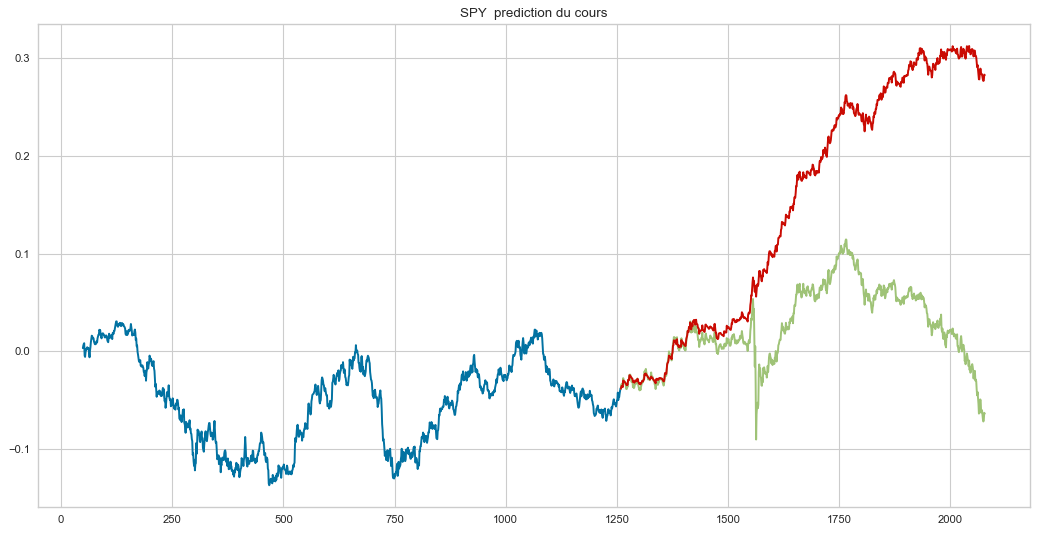

In [13]:
tmax = 5000
tmin = 6000
#from matplotlib import figure
plt.figure(figsize=(16,8),dpi=80)
plt.title(x+'  prediction du cours')
plt.plot(train_Data[x][str(x) + '_returns'][-tmin:].cumsum())
plt.plot(test_y[x][:tmax].cumsum()+train_Data[x][str(x) + '_returns'][-tmin:].cumsum().values[-1])
plt.plot(test_y[x][:tmax].index,futur_ret[x][:tmax].cumsum()*13+train_Data[x][str(x) + '_returns'][-tmin:].cumsum().values[-1])
plt.show()

#### Si on ne considere que quelques mois la prediction est meilleure

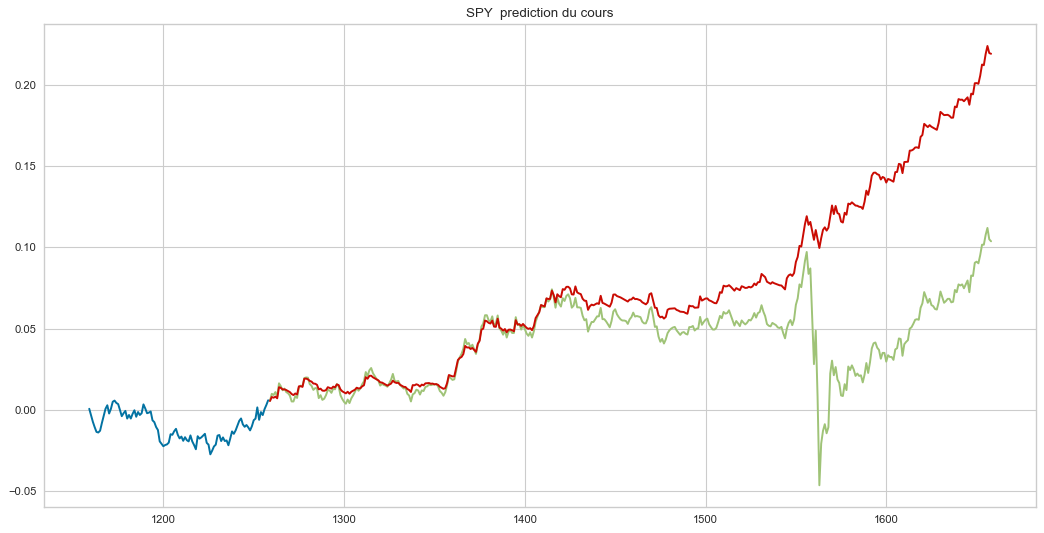

/Users/armand_morin/opt/anaconda3/envs/picard/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/armand_morin/opt/anaconda3/envs/picard/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute standard_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/armand_morin/opt/anaconda3/envs/picard/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_coef_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, category=FutureWarning)
/Users/armand_morin/opt/anaconda3/envs/picard/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute average_intercept_ was deprecated in version 0.23 and will be removed in 0.25.
  warnings.warn(msg, cate

In [14]:
tmax = 400
tmin = 100
#from matplotlib import figure
plt.figure(figsize=(16,8),dpi=80)
plt.title(x+'  prediction du cours')
plt.plot(train_Data[x][str(x) + '_returns'][-tmin:].cumsum())

plt.plot(test_y[x][:tmax].cumsum()+train_Data[x][str(x) + '_returns'][-tmin:].cumsum().values[-1])

plt.plot(test_y[x][:tmax].index,
         futur_ret[x][:tmax].cumsum()*13+train_Data[x][str(x) + '_returns'][-tmin:].cumsum().values[-1])
plt.show()

In [ ]:
from pycaret.regression import *

futur_ret = {}
for x in symbols:
    L = list(train_Data[x].columns)
    L.pop(1)
    Setup_ = setup(data = train_Data[x],
                   test_data = test_Data[x], 
                   target = str(x) + '_returns',  
                   fold = 5, 
                   log_experiment = False,
                   verbose = False,
                   normalize = True,
                   numeric_features = L,
                   session_id = 123,
                   transformation= True, 
                   transformation_method = 'yeo-johnson', 
                   remove_outliers= True,
                   remove_multicollinearity = True,
                   ignore_low_variance = True, 
                   combine_rare_levels = True)

    best = compare_models(sort = 'MAE',verbose = False,)
    best = create_model(best)
    best = tune_model(best)
    model = finalize_model(best)
    predictions = predict_model(model, data = test_Data[x],verbose = False,)
    print(np.sum((test_y[x].values - predictions['Label'].values)**2))

    futur_ret[x] = predictions['Label'].values